<a href="https://colab.research.google.com/github/REYY111/air-quality-model-comparison-india/blob/main/Tubes_PMA_Air_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM

Data digunakan untuk SVM: (100000, 26)

--- Membangun Model SVM ---
1. Melakukan Preprocessing...
2. Melakukan PCA...
3. Training SVM...
Training Selesai!

=== Laporan Evaluasi SVM ===
Akurasi: 0.77765

Classification Report:

                                precision    recall  f1-score   support

                          Good       0.83      0.80      0.81      3233
                      Moderate       0.81      0.87      0.84      9203
                     Unhealthy       0.81      0.73      0.77      3098
Unhealthy for Sensitive Groups       0.64      0.62      0.63      4118
                Very Unhealthy       0.76      0.49      0.60       348

                      accuracy                           0.78     20000
                     macro avg       0.77      0.70      0.73     20000
                  weighted avg       0.78      0.78      0.78     20000



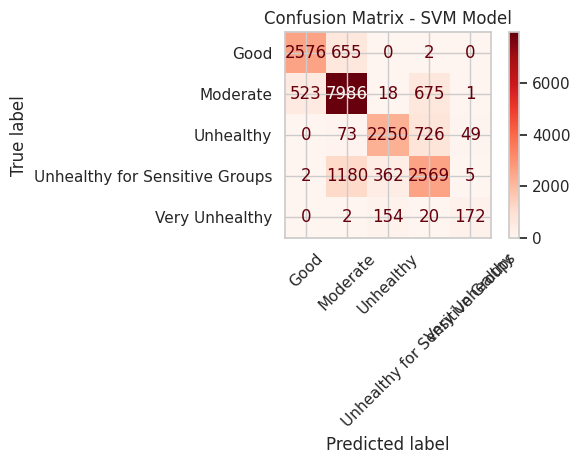

In [ ]:
# =========================================
# IMPORT LIBRARIES
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Library preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

## Model yang digunakan: Support Vector Machine
from sklearn.svm import SVC

## Evaluasi & split data
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

sns.set(style="whitegrid")   ## Style grafik seaborn

# =========================================
# 1. LOAD DATA
# =========================================
filename = "aqi_india_38cols_knn_final.csv"
try:
    df = pd.read_csv(filename, sep=None, engine='python', low_memory=False)
except:
    df = pd.read_csv(filename, sep=';', low_memory=False)

## Membaca dataset AQI dari file CSV

# =========================================
# 2. DATA CLEANING & DROP
# =========================================
## Normalisasi kolom boolean agar konsisten True/False
bool_cols = ["is_weekend", "is_raining", "heavy_rain", "festival_period", "crop_burning_season"]
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower().map({"true": True, "false": False})

## Menghapus kolom yang tidak dipakai untuk prediksi
df.drop(
    columns=["city", "state", "datetime", "us_aqi", "pm25_category_india"],
    inplace=True,
    errors="ignore"
)

# =========================================
# 3. SAMPLING (CRITICAL FOR SVM)
# =========================================
## SVM sangat berat jika data terlalu besar, jadi dibatasi maksimal 100.000
N_SAMPLE = min(100000, len(df))
df = df.sample(n=N_SAMPLE, random_state=42)
print(f"Data digunakan untuk SVM: {df.shape}")

## Menghapus kelas AQI yang hanya punya 1 data (tidak valid untuk klasifikasi)
class_counts = df["aqi_category"].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df = df[df["aqi_category"].isin(valid_classes)].reset_index(drop=True)

# =========================================
# 4. PREPROCESSING PIPELINE
# =========================================
## Memisahkan fitur dan label
X = df.drop(columns=["aqi_category"])
y = df["aqi_category"]

## Deteksi kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "bool"]).columns

## Pipeline preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ## Untuk data numerik: isi missing value → scaling
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())   ## Wajib untuk SVM
        ]), num_cols),

        ## Untuk data kategorikal: isi missing → one-hot encoding
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols)
    ]
)

# =========================================
# 5. SPLIT DATA
# =========================================
## Membagi data menjadi 80% training dan 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =========================================
# 6. MODELING: SVM ONLY
# =========================================
print("\n--- Membangun Model SVM ---")
print("1. Melakukan Preprocessing...")
print("2. Melakukan PCA...")
print("3. Training SVM...")

model_svm = Pipeline([
    ("prep", preprocessor),       ## Tahap preprocessing otomatis
    ("pca", PCA(n_components=0.95)), ## Reduksi dimensi: simpan 95% informasi
    ("svm", SVC(
        kernel='rbf',             ## Kernel RBF untuk data non-linear
        C=1.0,                    ## Parameter regularisasi
        gamma='scale',            ## Parameter kernel
        cache_size=1000,
        random_state=42
    ))
])

## Training model
model_svm.fit(X_train, y_train)
print("Training Selesai!")

# =========================================
# 7. EVALUASI
# =========================================
## Prediksi data uji
y_pred = model_svm.predict(X_test)

## Menampilkan performa model
print("\n=== Laporan Evaluasi SVM ===")
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

## Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model_svm.named_steps["svm"].classes_
)
disp.plot(cmap="Reds", xticks_rotation=45)
plt.title("Confusion Matrix - SVM Model")
plt.tight_layout()
plt.show()


# Random Forest

Data dipakai: (500000, 26)
Jumlah kelas akhir: 5
Minimum data per kelas: 8661

=== Laporan Evaluasi Random Forest ===
Akurasi: 0.74232

Classification Report:

                                precision    recall  f1-score   support

                          Good       0.80      0.76      0.77     16145
                      Moderate       0.78      0.84      0.81     45870
                     Unhealthy       0.74      0.72      0.73     15508
Unhealthy for Sensitive Groups       0.61      0.56      0.58     20745
                Very Unhealthy       0.74      0.44      0.55      1732

                      accuracy                           0.74    100000
                     macro avg       0.73      0.66      0.69    100000
                  weighted avg       0.74      0.74      0.74    100000



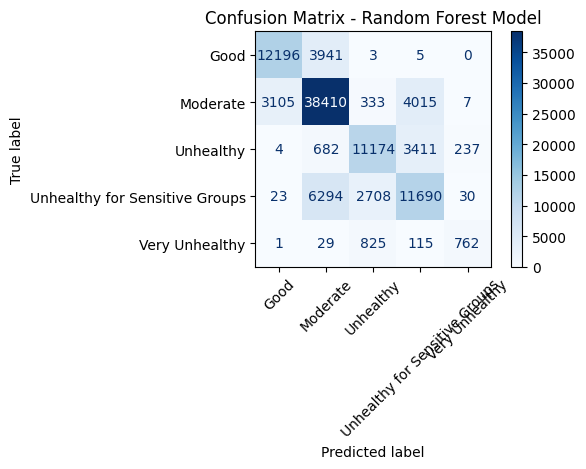


Anomaly result:
anomaly
Normal     29100
Anomaly      900
Name: count, dtype: int64


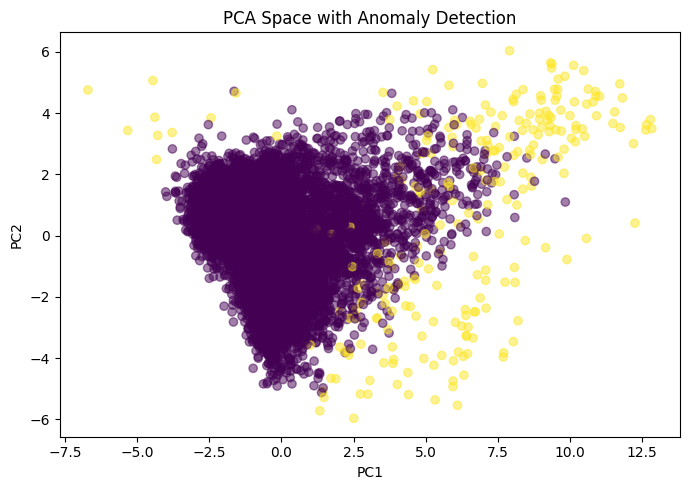

In [ ]:
# =========================================
# IMPORT
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, IsolationForest

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# =========================================
# 1. LOAD DATA
# =========================================
filename = "aqi_india_38cols_knn_final.csv"
try:
    df = pd.read_csv(filename, sep=None, engine='python', low_memory=False)
except:
    df = pd.read_csv(filename, sep=';', low_memory=False)

# =========================================
# 2. RAPIIKAN BOOLEAN (ANTI NaN)
# =========================================
bool_cols = [
    "is_weekend", "is_raining", "heavy_rain",
    "festival_period", "crop_burning_season"
]

for col in bool_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.strip()
            .str.lower()
            .map({"true": True, "false": False})
            .fillna(False)  # WAJIB
        )

# =========================================
# 3. DROP KOLOM TIDAK PERLU
# =========================================
df.drop(
    columns=["city", "state", "datetime", "us_aqi", "pm25_category_india"],
    inplace=True,
    errors="ignore"
)

# =========================================
# 4. SAMPLING AMAN
# =========================================
N_SAMPLE = min(500_000, len(df))
df = df.sample(n=N_SAMPLE, random_state=42)
print("Data dipakai:", df.shape)

# =========================================
# 5. DROP NaN TARGET (WAJIB)
# =========================================
df = df.dropna(subset=["aqi_category"]).reset_index(drop=True)

# =========================================
# 6. HAPUS KELAS TERLALU JARANG (STRATIFY SAFE)
# =========================================
class_counts = df["aqi_category"].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df = df[df["aqi_category"].isin(valid_classes)].reset_index(drop=True)

print("Jumlah kelas akhir:", df["aqi_category"].nunique())
print("Minimum data per kelas:", df["aqi_category"].value_counts().min())

# =========================================
# 7. TARGET & FITUR
# =========================================
X = df.drop(columns=["aqi_category"])
y = df["aqi_category"]

# =========================================
# 8. IDENTIFIKASI KOLOM
# =========================================
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "bool"]).columns

# =========================================
# 9. PREPROCESSING
# =========================================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False
            ))
        ]), cat_cols)
    ]
)

# =========================================
# 10. MODEL PIPELINE (RANDOM FOREST)
# =========================================
model = Pipeline([
    ("prep", preprocessor),
    ("pca", PCA(n_components=5, random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

# =========================================
# 11. TRAIN TEST SPLIT (AMAN)
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# TRAINING
model.fit(X_train, y_train)

# =========================================
# 12. EVALUASI MODEL (FORMAT SAMA DENGAN SVM)
# =========================================
y_pred = model.predict(X_test)

print("\n=== Laporan Evaluasi Random Forest ===")
print("Akurasi:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    zero_division=0
))

# =========================================
# 13. CONFUSION MATRIX
# =========================================
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model.named_steps["rf"].classes_
)

disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest Model")
plt.tight_layout()
plt.show()

# =========================================
# 14. ANOMALY DETECTION (TRAIN SET SAJA)
# =========================================
X_train_prep = model.named_steps["prep"].transform(X_train)
X_train_pca = model.named_steps["pca"].transform(X_train_prep)

N_ANOM = min(30_000, len(X_train_pca))
idx = np.random.choice(len(X_train_pca), N_ANOM, replace=False)

iso = IsolationForest(
    n_estimators=100,
    contamination=0.03,
    random_state=42
)

anom_label = iso.fit_predict(X_train_pca[idx])

df_anom = X_train.iloc[idx].copy()
df_anom["anomaly"] = np.where(anom_label == -1, "Anomaly", "Normal")

print("\nAnomaly result:")
print(df_anom["anomaly"].value_counts())

# =========================================
# 15. VISUALISASI PCA + ANOMALI
# =========================================
N_VIZ = min(8_000, len(idx))

X_viz = X_train_pca[idx][:N_VIZ]
viz_anom = df_anom["anomaly"].iloc[:N_VIZ] == "Anomaly"

plt.figure(figsize=(7, 5))
plt.scatter(X_viz[:, 0], X_viz[:, 1], c=viz_anom, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Space with Anomaly Detection")
plt.tight_layout()
plt.show()


# Decision Tree

Data dipakai: (500000, 26)

Accuracy: 0.7214

Classification Report:
                                precision    recall  f1-score   support

                          Good     0.7110    0.8941    0.7921     16145
                      Moderate     0.8712    0.6846    0.7667     45870
                     Unhealthy     0.7447    0.6629    0.7014     15508
Unhealthy for Sensitive Groups     0.5574    0.7023    0.6215     20745
                Very Unhealthy     0.3920    0.8395    0.5345      1732

                      accuracy                         0.7214    100000
                     macro avg     0.6553    0.7567    0.6833    100000
                  weighted avg     0.7523    0.7214    0.7266    100000



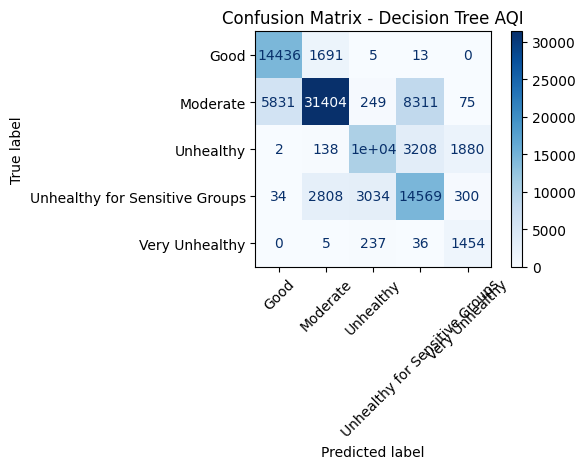


Hasil Anomaly Detection:
Normal  : 388000
Anomaly : 12000


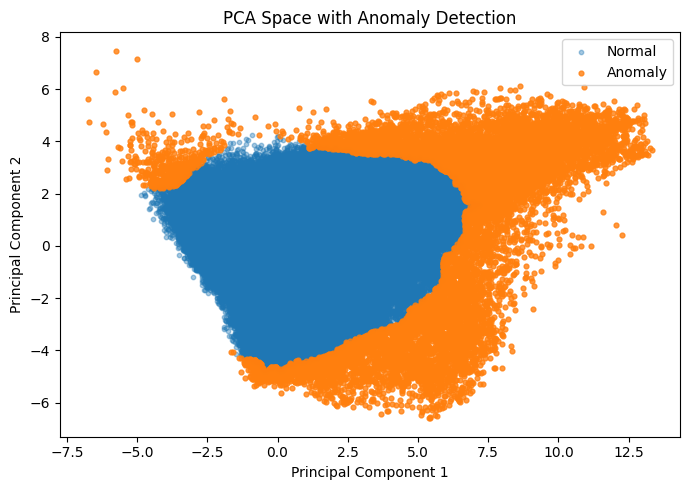

In [ ]:
# =========================================
# IMPORT
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest


# =========================================
# 1. LOAD DATA
# =========================================
filename = "aqi_india_38cols_knn_final.csv"
try:
    df = pd.read_csv(filename, sep=None, engine='python', low_memory=False)
except:
    df = pd.read_csv(filename, sep=';', low_memory=False)



# =========================================
# 2. RAPIIKAN BOOLEAN
# =========================================
bool_cols = [
    "is_weekend", "is_raining", "heavy_rain",
    "festival_period", "crop_burning_season"
]

for col in bool_cols:
    if col in df.columns:
        df[col] = (
            df[col].astype(str)
            .str.lower()
            .map({"true": True, "false": False})
        )


# =========================================
# 3. DROP KOLOM TIDAK PERLU
# =========================================
df.drop(
    columns=["city", "state", "datetime", "us_aqi", "pm25_category_india"],
    inplace=True,
    errors="ignore"
)


# =========================================
# 4. SAMPLING (AMAN UNTUK COLAB)
# =========================================
N_SAMPLE = min(500_000, len(df))
df = df.sample(n=N_SAMPLE, random_state=42)

print("Data dipakai:", df.shape)


# =========================================
# 5. TARGET & FITUR
# =========================================
X = df.drop(columns=["aqi_category"])
y = df["aqi_category"]


# =========================================
# 6. IDENTIFIKASI KOLOM
# =========================================
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "bool"]).columns


# =========================================
# 7. PREPROCESSING
# =========================================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False
            ))
        ]), cat_cols)
    ]
)


# =========================================
# 8. MODEL: DECISION TREE
# =========================================
model = Pipeline([
    ("prep", preprocessor),
    ("dt", DecisionTreeClassifier(
        max_depth=12,
        min_samples_split=10,
        class_weight="balanced",
        random_state=42
    ))
])


# =========================================
# 9. TRAIN TEST SPLIT
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


# =========================================
# 10. TRAIN MODEL
# =========================================
model.fit(X_train, y_train)


# =========================================
# 11. EVALUASI KLASIFIKASI
# =========================================
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(
    y_test,
    y_pred,
    digits=4
))


# =========================================
# 12. CONFUSION MATRIX
# =========================================
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model.named_steps["dt"].classes_
)

disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Decision Tree AQI")
plt.tight_layout()
plt.show()


# =========================================
# 13. ANOMALY DETECTION (DATA TRAIN SAJA)
# =========================================
# Preprocessing tanpa classifier
X_train_prep = model.named_steps["prep"].transform(X_train)

# PCA ke 2 dimensi (untuk visualisasi)
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_prep)

# Isolation Forest
iso = IsolationForest(
    n_estimators=150,
    contamination=0.03,
    random_state=42
)

anom_label = iso.fit_predict(X_train_pca)
anom_flag = anom_label == -1

print("\nHasil Anomaly Detection:")
print("Normal  :", np.sum(~anom_flag))
print("Anomaly :", np.sum(anom_flag))


# =========================================
# 14. VISUALISASI PCA + ANOMALI
# =========================================
plt.figure(figsize=(7, 5))

plt.scatter(
    X_train_pca[~anom_flag, 0],
    X_train_pca[~anom_flag, 1],
    s=10,
    alpha=0.4,
    label="Normal"
)

plt.scatter(
    X_train_pca[anom_flag, 0],
    X_train_pca[anom_flag, 1],
    s=12,
    alpha=0.8,
    label="Anomaly"
)

plt.title("PCA Space with Anomaly Detection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-3190377930.py:9: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";")



Distribusi AQI:
                     AQI_Category   Count
0                        Moderate  385833
1  Unhealthy for Sensitive Groups  175125
2                            Good  136476
3                       Unhealthy  130360
4                  Very Unhealthy   14366


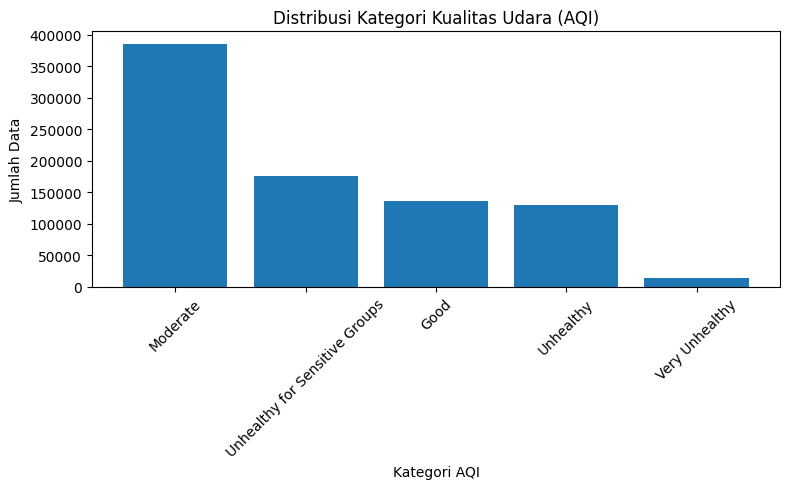


Statistik Polutan:
          pm2_5_ugm3      pm10_ugm3       no2_ugm3       so2_ugm3  \
count  842160.000000  842160.000000  842160.000000  842160.000000   
mean       34.549825      54.014723      15.991785      13.390032   
std        29.652013      54.231554      19.896299      18.921014   
min         1.900000       2.300000       0.000000       0.200000   
25%        14.700000      21.500000       3.700000       2.800000   
50%        25.900000      39.000000       9.000000       6.900000   
75%        44.200000      66.400000      19.900000      15.800000   
max       183.500000     420.000000     122.100000     134.200000   

             co_ugm3        o3_ugm3  
count  842160.000000  842160.000000  
mean      444.932728      80.188893  
std       377.007222      44.762719  
min        96.000000       0.000000  
25%       235.000000      47.000000  
50%       333.000000      73.000000  
75%       508.000000     108.000000  
max      2903.000000     228.000000  


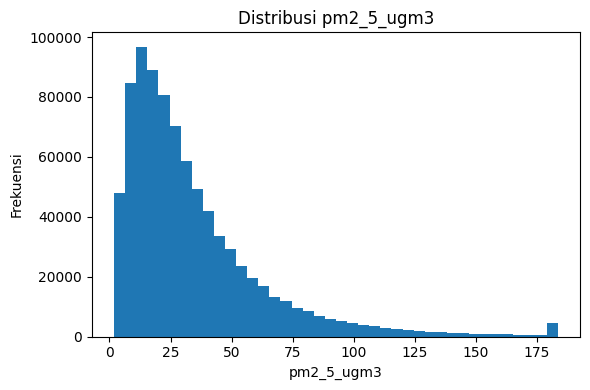

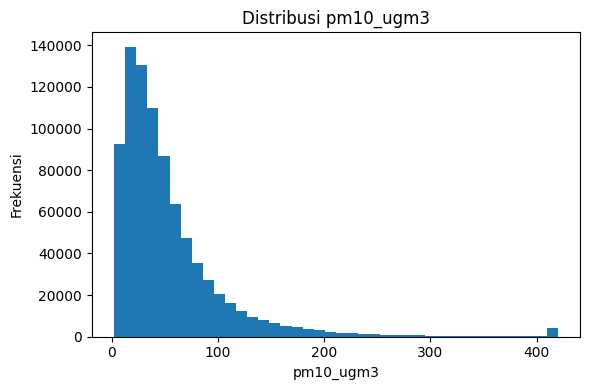

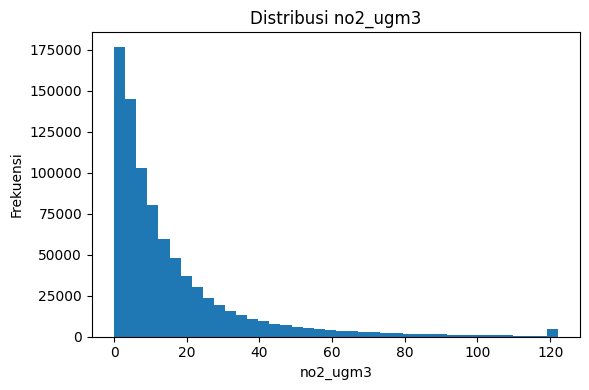

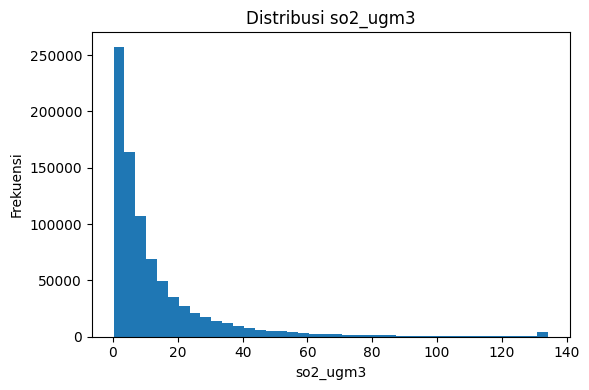

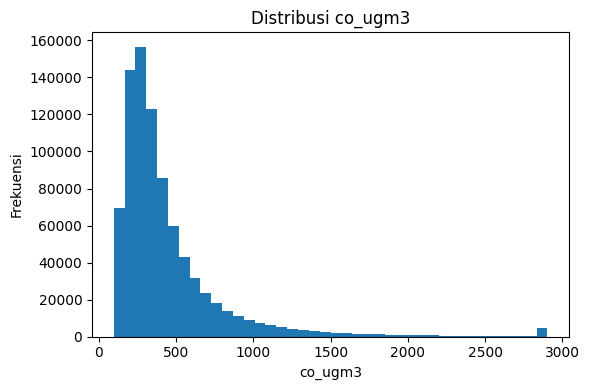

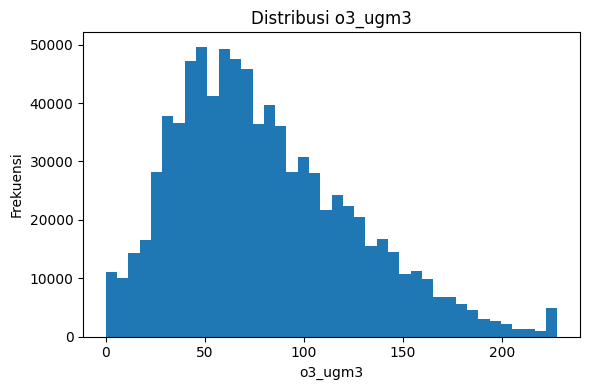


10 Kota dengan Data Terbanyak:
city
agartala       29040
ahmedabad      29040
aizawl         29040
bengaluru      29040
bhopal         29040
bhubaneswar    29040
chandigarh     29040
chennai        29040
dehradun       29040
delhi          29040
Name: count, dtype: int64


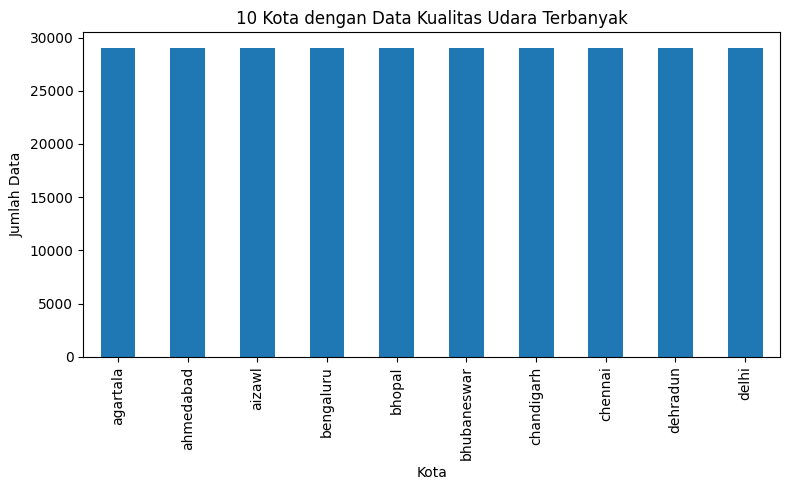

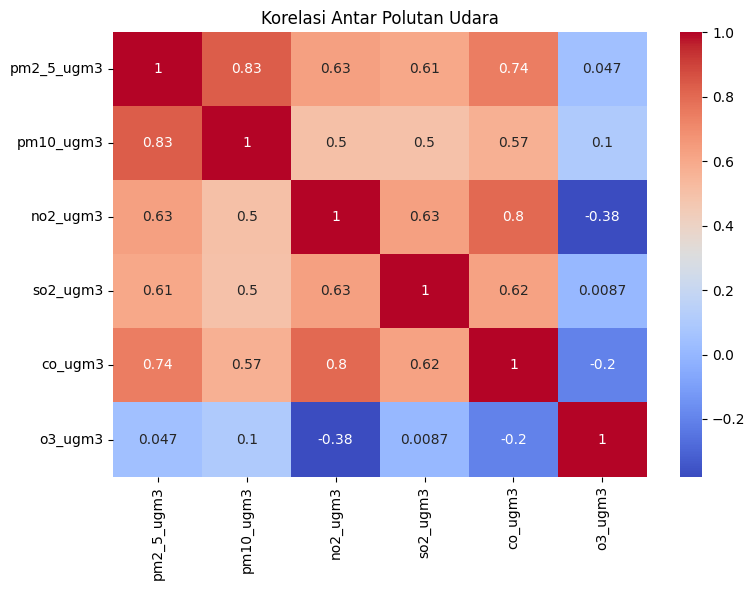


Rata-rata Polutan per Kategori AQI:
                                pm2_5_ugm3   pm10_ugm3   no2_ugm3   so2_ugm3  \
aqi_category                                                                   
Good                              8.945204   13.277415   5.945821   2.604677   
Moderate                         22.658121   35.151740  11.410327   8.601797   
Unhealthy                        76.955859  114.374072  32.677389  31.945278   
Unhealthy for Sensitive Groups   42.570939   66.779404  19.190086  16.256685   
Very Unhealthy                  114.591584  244.308917  44.077043  41.130315   

                                    co_ugm3     o3_ugm3  
aqi_category                                             
Good                             222.245743   55.651844  
Moderate                         336.727162   76.812144  
Unhealthy                        840.012120   92.737481  
Unhealthy for Sensitive Groups   511.831263   94.795323  
Very Unhealthy                  1066.020813  112.05540

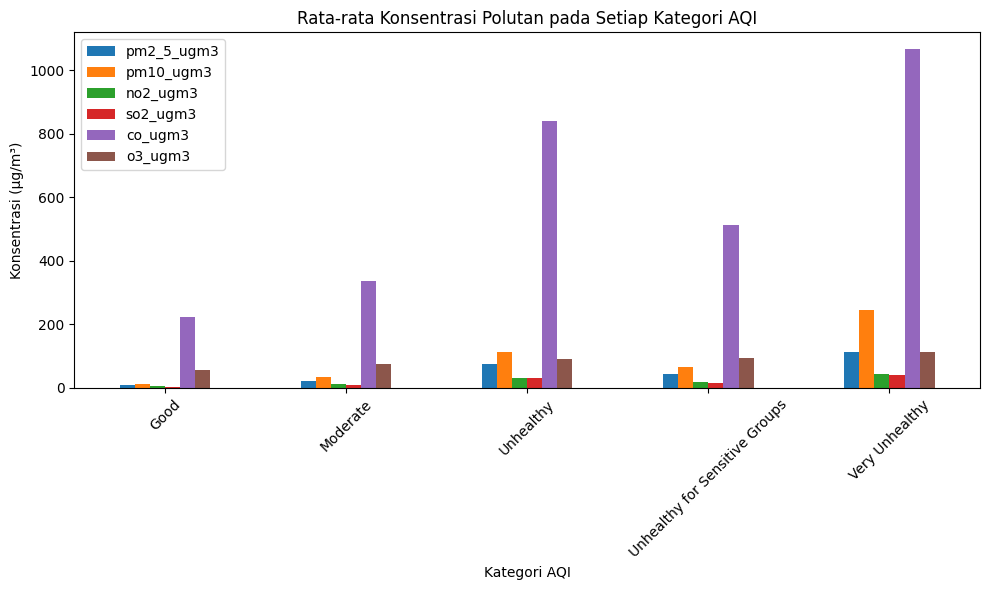

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =======================
# LOAD DATA (FIX DELIMITER)
# =======================
file_path = "/content/aqi_india_38cols_knn_final.csv"
df = pd.read_csv(file_path, sep=";")

# =======================
# KONVERSI KOLOM NUMERIK
# =======================
numeric_cols = [
    "latitude","longitude","humidity_percent","dew_point_c",
    "wind_gusts_kmh","precipitation_mm","pressure_msl_hpa",
    "cloud_cover_percent","pm2_5_ugm3","pm10_ugm3",
    "co_ugm3","no2_ugm3","so2_ugm3","o3_ugm3",
    "dust_ugm3","aod","us_aqi"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# =======================
# 1. DISTRIBUSI AQI
# =======================
aqi_dist = df["aqi_category"].value_counts().reset_index()
aqi_dist.columns = ["AQI_Category","Count"]
print("\nDistribusi AQI:")
print(aqi_dist)

plt.figure(figsize=(8,5))
plt.bar(aqi_dist["AQI_Category"], aqi_dist["Count"])
plt.title("Distribusi Kategori Kualitas Udara (AQI)")
plt.xlabel("Kategori AQI")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =======================
# 2. STATISTIK POLUTAN
# =======================
pollutants = ["pm2_5_ugm3","pm10_ugm3","no2_ugm3","so2_ugm3","co_ugm3","o3_ugm3"]
print("\nStatistik Polutan:")
print(df[pollutants].describe())

# =======================
# 3. HISTOGRAM POLUTAN
# =======================
for pol in pollutants:
    plt.figure(figsize=(6,4))
    plt.hist(df[pol].dropna(), bins=40)
    plt.title(f"Distribusi {pol}")
    plt.xlabel(pol)
    plt.ylabel("Frekuensi")
    plt.tight_layout()
    plt.show()

# =======================
# 4. 10 KOTA TERBANYAK DATA
# =======================
city_dist = df["city"].value_counts().head(10)
print("\n10 Kota dengan Data Terbanyak:")
print(city_dist)

plt.figure(figsize=(8,5))
city_dist.plot(kind="bar")
plt.title("10 Kota dengan Data Kualitas Udara Terbanyak")
plt.xlabel("Kota")
plt.ylabel("Jumlah Data")
plt.tight_layout()
plt.show()

# =======================
# 5. KORELASI POLUTAN
# =======================
corr = df[pollutants].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Korelasi Antar Polutan Udara")
plt.tight_layout()
plt.show()

# =======================
# 6. RATA-RATA POLUTAN vs AQI
# =======================
avg_by_aqi = df.groupby("aqi_category")[pollutants].mean()
print("\nRata-rata Polutan per Kategori AQI:")
print(avg_by_aqi)

avg_by_aqi.plot(kind="bar", figsize=(10,6))
plt.title("Rata-rata Konsentrasi Polutan pada Setiap Kategori AQI")
plt.xlabel("Kategori AQI")
plt.ylabel("Konsentrasi (µg/m³)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# =========================================
# IMPORT LIBRARIES
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

sns.set(style="whitegrid")

# =========================================
# 1. LOAD DATA
# =========================================
filename = "aqi_india_38cols_knn_final.csv"
try:
    df = pd.read_csv(filename, sep=None, engine="python", low_memory=False)
except:
    df = pd.read_csv(filename, sep=";", low_memory=False)

# =========================================
# 2. CLEANING
# =========================================
bool_cols = ["is_weekend", "is_raining", "heavy_rain", "festival_period", "crop_burning_season"]
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower().map({"true": True, "false": False})

df.drop(columns=["city","state","datetime","us_aqi","pm25_category_india"], inplace=True, errors="ignore")

# =========================================
# 3. SAMPLING
# =========================================
N_SAMPLE = min(100000, len(df))
df = df.sample(n=N_SAMPLE, random_state=42)

class_counts = df["aqi_category"].value_counts()
df = df[df["aqi_category"].isin(class_counts[class_counts >= 5].index)]

# =========================================
# 4. SPLIT
# =========================================
X = df.drop(columns=["aqi_category"])
y = df["aqi_category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =========================================
# 5. PREPROCESSING
# =========================================
num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(include=["object","bool"]).columns

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_cols)
])

# =========================================
# 6. PIPELINE
# =========================================
pipeline = Pipeline([
    ("prep", preprocessor),
    ("pca", PCA()),
    ("svm", SVC(kernel="rbf", class_weight="balanced"))
])

# =========================================
# 7. HYPERPARAMETER TUNING
# =========================================
param_grid = {
    "pca__n_components": [0.90, 0.95, 0.98],
    "svm__C": [0.5, 1, 5, 10],
    "svm__gamma": ["scale", 0.01, 0.05, 0.1]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1_macro",   # CRITICAL for imbalance
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("\nTraining optimized balanced SVM...")
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("\nBest Parameters:", grid.best_params_)

# =========================================
# 8. EVALUATION
# =========================================
y_pred = best_model.predict(X_test)

print("\n=== Optimized Balanced SVM ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=best_model.named_steps["svm"].classes_)
disp.plot(cmap="Reds", xticks_rotation=45)
plt.title("Confusion Matrix - Optimized Balanced SVM")
plt.tight_layout()
plt.show()

# =========================================
# 9. SAVE
# =========================================
joblib.dump(best_model, "svm_aqi_optimized_balanced.pkl")
print("Model saved as svm_aqi_optimized_balanced.pkl")



Training optimized balanced SVM...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
